In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import warnings
warnings.filterwarnings("ignore")

Problem 1

(a)

In [28]:
inc = pd.read_csv("data/incomes.txt", names=["income"])

In [41]:
inc.head()
income = inc["income"]

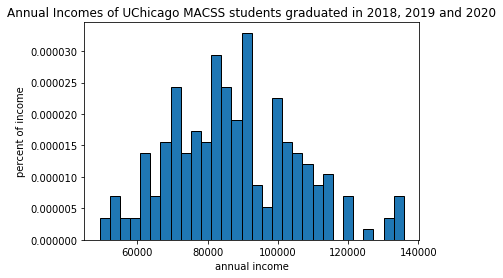

In [42]:
plt.hist(inc["income"], bins=30, normed=True, edgecolor="k" )
plt.xlabel("annual income")
plt.ylabel("percent of income")
plt.title("Annual Incomes of UChicago MACSS students graduated in 2018, 2019 and 2020")
plt.show()

(b)

In [43]:
# Define function that generates values of a lognormal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals  = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [55]:
def lognorm_pdf(xvals, mu, sigma):
    pdf_vals  = (1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))  
    return pdf_vals

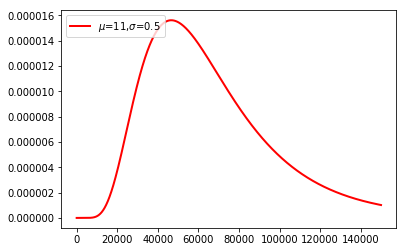

In [44]:
dist_pts = np.linspace(1, 150000, 3000)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1,sig_1, 0, 150000),
         linewidth=2, color='r', label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')
plt.show()

In [57]:
# Define log likelihood function for the lognormal distribution
def log_lik_norm(xvals, mu, sigma):

    lognorm_pdf_vals = lognorm_pdf(xvals, mu, sigma)
    ln_lognorm_pdf_vals = np.log(lognorm_pdf_vals)
    log_lik_val = ln_lognorm_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood value is: ', log_lik_norm(income, 11, 0.5))

Log-likelihood value is:  -2385.856997808558


(c)

In [65]:
def crit(params, *args):
   
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_norm(xvals, mu, abs(sigma))
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [66]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
mle_args = (income, 'None', 'None')
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results_uncstr.x
loglik_val_MLE = log_lik_norm(income, mu_MLE, sig_MLE)

print('ML estimates for mu is', mu_MLE)
print('ML estimates for sigma is', sig_MLE)
print('The value of the likelihood function is: ', loglik_val_MLE)


ML estimates for mu is 11.359022994653781
ML estimates for sigma is 0.2081773174914064
The value of the likelihood function is:  -2241.7193013573587


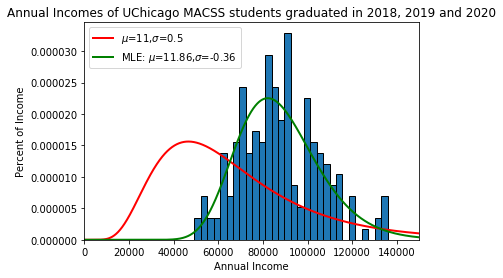

In [36]:
plt.hist(inc['income'], bins=30, normed=True, edgecolor='k')

# Plot the PDF from (b)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1, sig_1, 0, 150000),
         linewidth=2, color='r',  label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_MLE,sig_MLE, 0, 150000),
         linewidth=2, color='g', label='MLE: $\mu$=11.86,$\sigma$=-0.36')
plt.legend(loc='upper left')
 
plt.title('Annual Incomes of UChicago MACSS students graduated in 2018, 2019 and 2020')
plt.xlabel('Annual Income')
plt.ylabel('Percent of Income')
plt.xlim([0, 150000]) 
plt.show()


In [48]:
vcv_mle = results_uncstr.hess_inv

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)
print('mu percent', 100*stderr_mu_mle/mu_MLE,"%")
print('sig percent', 100*stderr_sig_mle/sig_MLE,"%")

VCV(MLE) =  [[2.21084259e-04 2.17316112e-06]
 [2.17316112e-06 1.09454660e-04]]
Standard error for mu estimate =  0.014868902408040419
Standard error for sigma estimate =  0.010462058107203465
mu percent 0.1308994833009722 %
sig percent 5.025551406500058 %


(d)

In [49]:
mu_new, sig_new = np.array([420, 130])
log_lik_h0 = log_lik_trunclognorm(inc['income'], mu_1, sig_1, 0, 150000)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_trunclognorm(inc['income'], mu_MLE, sig_MLE, 0, 150000)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2379.120591931827
MLE log likelihood -2240.996978489331
likelihood ratio value 276.2472268849924
chi squared of H0 with 2 degrees of freedom p-value =  0.0


Since p-value is very small, we can reject the null hypothesis that the probability that the data comes from is f(x|mu=11,sigma=0.5).

e

In [13]:
1-sts.lognorm.cdf(100000, sig_MLE, scale=np.exp(mu_MLE))

0.2375540357115089

There is 23.76% of the chance that I will earn more than $100000.

In [14]:
sts.lognorm.cdf(75000, sig_MLE, scale=np.exp(mu_MLE))

0.25964393792847373

There is 25.96% of the chance that I will earn less than $75000.

Problem 2

(a)

In [15]:
import pandas as pd
import numpy as np
sick = pd.read_csv("data/sick.txt")
sick.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [16]:
def norm_pdf(xvals, sig):
    sig=abs(sig)
    pdf_vals = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(xvals)**2 / (2*sig**2))                  
    return pdf_vals

In [50]:
def log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sig):   
    err = y-b0-b1*x1-b2*x2-b3*x3
    pdf_vals = norm_pdf(err, sig)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [51]:
def crit2(params,*args):
    
    b0, b1, b2, b3, sig = params
    y, x1, x2, x3 = args
    log_lik_val = log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sig)
    neg_log_lik_val = -log_lik_val 
    
    return neg_log_lik_val

In [52]:
b0_init, b1_init, b2_init, b3_init, sig_init = (0.2,0,0,0,1)
y = sick['sick']
x1, x2, x3 = sick['age'], sick['children'], sick['avgtemp_winter']
params_init = np.array([b0_init, b1_init, b2_init, b3_init, sig_init])
results = opt.minimize(crit2, params_init,(y, x1, x2, x3))
b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE = results.x
print('beta 0=', b0_MLE)
print('beta 1=', b1_MLE)
print('beta 2=', b2_MLE)
print('beta 3=', b3_MLE)
print('sigma=', sig_MLE)
print("Value of the log likelihood function:",-results.fun)

beta 0= 0.25164657743236246
beta 1= 0.012933389662209218
beta 2= 0.40050177159977757
beta 3= -0.00999170144778414
sigma= 0.003017676295795841
Value of the log likelihood function: 876.8650477456889


In [20]:
vcv_mle = results.hess_inv
print('VCV(MLE) = ', vcv_mle)

VCV(MLE) =  [[ 1.02601558e-06  6.76217712e-09 -1.61457419e-07 -2.23447561e-08
  -2.62509024e-09]
 [ 6.76217712e-09  3.99882010e-09 -3.59520203e-08 -2.49007806e-09
  -2.98856777e-10]
 [-1.61457419e-07 -3.59520203e-08  3.75727605e-07  2.26789439e-08
   4.78055308e-10]
 [-2.23447561e-08 -2.49007806e-09  2.26789439e-08  1.95181525e-09
   2.90327774e-10]
 [-2.62509024e-09 -2.98856777e-10  4.78055308e-10  2.90327774e-10
   2.29769926e-08]]


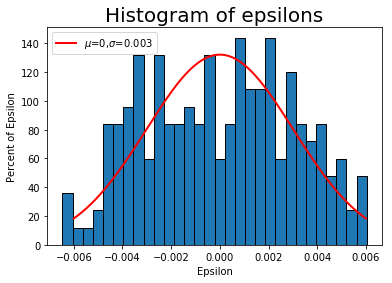

In [24]:
plt.hist(y-b0_MLE-b1_MLE*x1-b2_MLE*x2-b3_MLE*x3, bins=30, normed=True, edgecolor='k')

dist_pts = np.linspace(-0.006,0.006,1000)
plt.plot(dist_pts, norm_pdf(dist_pts, sig_MLE),
         linewidth=2, color='r', label='$\mu$=0,$\sigma$=0.003')
plt.legend(loc='upper left', fontsize=10)

plt.title('Histogram of epsilons', fontsize=20)
plt.xlabel('Epsilon')
plt.ylabel('Percent of Epsilon')
plt.show()

(b)

In [26]:
b0_t, b1_t, b2_t, b3_t, sig_t = 1, 0, 0, 0, 0.1
log_lik_h0 = log_lik_norm(y, x1, x2, x3, b0_t, b1_t, b2_t, b3_t, sig_t)
print('hypothesis value log likelihood', log_lik_h0)
print('MLE log likelihood', -results.fun)
LR_val = 2 * ((-results.fun)-log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('Chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2253.700688042125
MLE log likelihood 876.8650477456889
likelihood ratio value 6261.131471575628
Chi squared of H0 with 5 degrees of freedom p-value =  0.0


From above results, we know that p-value is very small, so we can reject the null hypothesis that age, number of children, and average winter temperature have no effect on the number of sick days. Thus, it's unlikely that age, number of children, and average winter temperature have no effect on the number of sick days.